#  Notebook with computations for Ch.14 From Prediction to Decisions

In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.colors as colors
import cycler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score


# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {'titlesize' : 22,
        'labelsize' : 20,
       'prop_cycle' : cycler.cycler(color='k')}
lines = {'color' : 'k'}
figure = {'figsize' : (10,4),
         'autolayout' : True,}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)
matplotlib.rc('lines', **lines)


### Simulate a latent variable classification model

1. Simulate a DGP with 3 features
2. Train a model using only 2 features (the omitted variable delivers more realistic results)

In [498]:
def balance_data(ydf, xdf, method='over'):
    '''
    ydf: Y: usually Ytrain
    xdf: X: usually Xtrain
    type: ['over','under']
    '''
    ydf = pd.Series(ydf, index = xdf.index)
    # find minority class: if mean < 0.5 -> minority class = 1
    min_class = 1*(ydf.mean() < 0.5)
    # get indices for classes
    loc_min = ydf == min_class
    min_ix = ydf[loc_min].index
    max_ix = ydf[loc_min==False].index
    n_min = len(min_ix)
    n_max = len(max_ix)
    if method == 'over':
        num_sml = n_max//n_min
        sml_ix = np.random.choice(min_ix, size = n_max, replace = True)
        sml_all = np.concatenate((sml_ix, max_ix),axis = 0)
    elif method == 'under':
        sml_ix = np.random.choice(max_ix, size = n_min, replace = True)
        sml_all = np.concatenate((sml_ix, min_ix),axis = 0)
    # ready to assemble everything
    y_new = ydf[sml_all].values
    x_new = xdf.loc[sml_all]
    return y_new, x_new

In [499]:
class MyRandClassifier:
    """
    Create a classifier that generates a random uniform prediction probabilities
    Serves as a benchmark against informative learners
    """
    def predict_proba(self, X, seed=2506):
        "Random prediction with probability proba"
        np.random.seed(seed)
        nobs, _ = X.shape
        prob = np.random.rand(nobs,1)
        one_minus_p = 1-prob
        prob_arr = np.concatenate((prob, one_minus_p), axis=1)
        
        return prob_arr


In [500]:
def simu_latent_missing(alpha, var_epsilon, num_observed, seed, nobs, pct_imb):
    """
    Simulate a latent variable classification model where the true DGP
        has K features and user observes L (L<=K)
    Inputs:
        alpha: array of floats: coefficients for linear latent model variable
        var_epsilon: variance of normally distributed noise
        num_observed: number of observed features (should be lower than len(alpha))
        seed: random number generator seed
        nobs: number of observations
        pct_imb: float in (0,1): fraction of 1s in the sample (0.5 --> balanced)
    outputs:
        ydf: simulated 1/0s from latent variable
        xdf: observed features (I take the first num_observed)
    """
    # simple linear latent variable model with three features
    np.random.seed(seed)
    nvars = len(alpha)-1 # since alpha includes intercept
    # simulate standard normals for the true features
    prexdf = pd.DataFrame(np.random.randn(nobs,nvars), columns = [f'x{d}' for d in range(1,nvars+1)])
    prexdf['x0'] = 1
    prexdf = prexdf[[f'x{d}' for d in range(nvars+1)]]
    var_eps = var_epsilon
    epsilon = np.sqrt(var_eps)*np.random.randn(nobs)
    # simulate the latent variable
    z = np.dot(prexdf, alpha) + epsilon
    # set imbalancedness 
    thresh = np.quantile(z, 1-pct_imb)
    y = 1*(z>=thresh)
    meany = (100*np.mean(y)).round(decimals=2)
    print(f'% of 1s = {meany}%')

    # subset to be used as features
    if num_observed > len(alpha):
        num_observed = len(alpha)
    cols_obs = ['x0'] + [f'x{d}' for d in range(1,nvars+1)][:num_observed]
    xdf = prexdf[cols_obs]

    # test that this was done correctly
    mysum = 0
    ix = 10
    for i in range(4):
        mysum += prexdf[prexdf.columns[i]].loc[ix]*alpha[i]
    mysum += epsilon[ix]
    assert mysum==z[ix]    
    
    return y, xdf

In [501]:
seed = 84516
nobs = 5000
alpha = [1,-1,2,-2]
var_epsilon = 10
num_observed = 3
pct_imb = 0.5

yt, xt = simu_latent_missing(alpha, var_epsilon, num_observed, seed, nobs, pct_imb)

% of 1s = 50.0%


In [502]:
# train a logistic regression on a subset of features: xdf (vs. zdf)
X_train, X_test, y_train, y_test = train_test_split(xt, yt, test_size=0.25, random_state=2506)
reg = LogisticRegression(random_state=0).fit(X_train, y_train)

# I also want my random classifier
rand_reg = MyRandClassifier()
#rand_reg.predict_proba(seed=1, proba=0.5, xdf=xdf)

In [503]:
def calculate_precision(model, num_groups, xdf, y, inverse_prob = False):
    """
    Calculate precision for different buckets
    Inputs:
        model: model object (must include the method predict_proba())
        num_groups: grid size to calculate the thresholds (num_groups <= cardinality(proba))
        xdf: df with features
        y: array with observed labels 1/0
        inverse_prob: Boolean: if true, use the probability of class 0
    """
    yhat = model.predict_proba(xdf)[:,1]
    if inverse_prob:
        yhat = model.predict_proba(xdf)[:,0]
    grid = np.quantile(yhat, np.linspace(0,1,num_groups+1))[:-1]
    #grid = np.quantile(yhat, np.linspace(0,1,num_groups+1))
    cols = ['tp','tn','fp','fn','precision', 'recall','fpr', 'volume', 'skl_recall', 'skl_precision']
    df_results = pd.DataFrame(index=grid, columns = cols, dtype='float')
    for g,grd in enumerate(grid):
        # select sample for this point of the grid
        loc_g = yhat>=grd
        nobs_g = 100*np.mean(loc_g) # normalize everything to population size = 100
        # compute confusion matrix for this point in the grid
        c_mat = pd.crosstab(y, 1*(loc_g))
        # handle border cases
        cols_cmat = c_mat.columns
        if 0 not in cols_cmat:
            c_mat[0] = 0
        elif 1 not in cols_cmat:
            c_mat[1] = 0
        tp = c_mat[1].loc[1]
        tn = c_mat[0].loc[0]
        fp = c_mat[1].loc[0]
        fn = c_mat[0].loc[1]
        df_results.tp.loc[grd] = tp
        df_results.tn.loc[grd] = tn
        df_results.fp.loc[grd] = fp
        df_results.fn.loc[grd] = fn
        # as a check, use Scikit-learns recall & precision
        s_rec = recall_score(y_true=y, y_pred=1*(loc_g))
        s_pre = precision_score(y_true=y, y_pred=1*(loc_g))
        df_results.skl_recall.loc[grd] = s_rec
        df_results.skl_precision.loc[grd] = s_pre
        # calculate precision and recall
        precision_g = tp/(tp+fp)
        recall_g = tp/(tp+fn)
        pre_g = np.mean(y[loc_g]==1)
        df_results.precision.loc[grd] = precision_g
        df_results.recall.loc[grd] = recall_g
        # to compute the ROC curve let's get one more
        fpr = fp/(fp+tn)
        df_results.fpr.loc[grd] = fpr
        # include volume
        df_results.volume.loc[grd] = nobs_g
        # volume x precision
    df_results['volume_precision'] = df_results.volume*df_results.precision

    return df_results


In [504]:
df_pr = calculate_precision(model=reg, num_groups=50, xdf=X_test, y=y_test)
df_pr_inv = calculate_precision(model=reg, num_groups=50, xdf=X_test, y=y_test, inverse_prob=True)
df_pr_rnd = calculate_precision(model=rand_reg, num_groups=50, xdf=X_test, y=y_test)

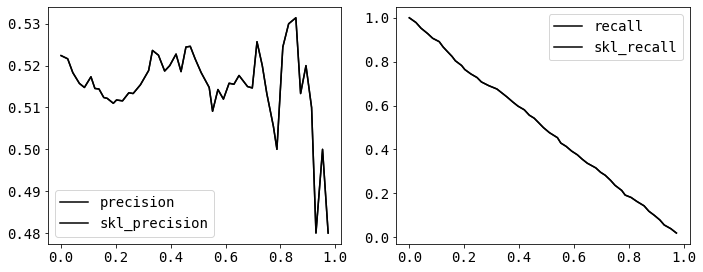

In [505]:
# check with scikit-learn
fig, ax = plt.subplots(1,2)
df_pr_rnd[['precision', 'skl_precision']].plot(ax=ax[0])
df_pr_rnd[['recall', 'skl_recall']].plot(ax=ax[1])

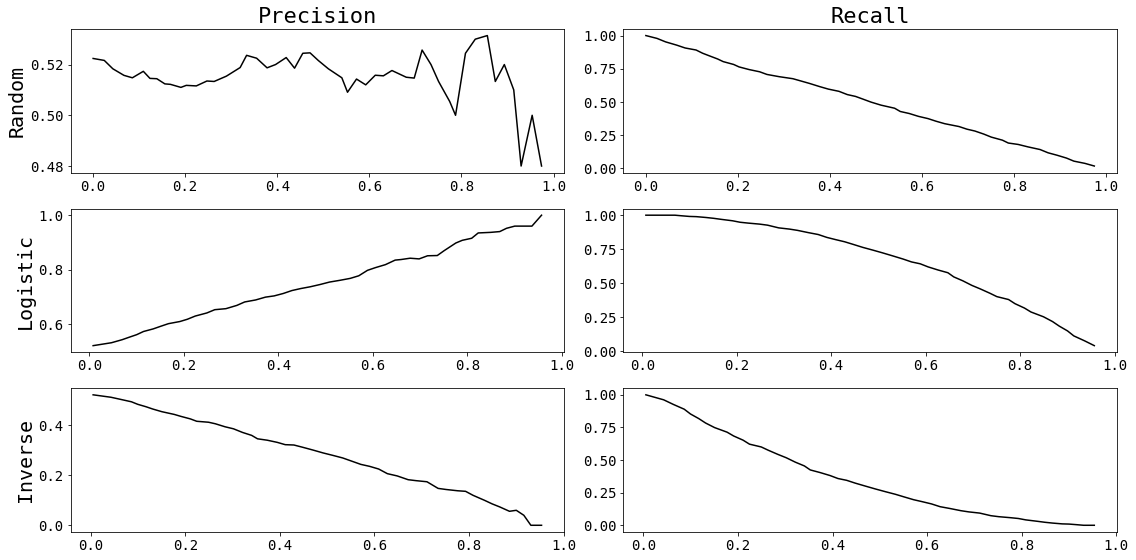

In [506]:
# plot precision and recall for random and not random
fig, ax = plt.subplots(3,2, figsize = (16,8))
dict_df = {0:df_pr_rnd, 1:df_pr, 2:df_pr_inv}
dict_ylab = {0:'Random', 1:'Logistic', 2:'Inverse'}
for i in range(3):
    df_i = dict_df[i]
    for k,metric in enumerate(['precision','recall']):
        df_i[metric].plot(ax=ax[i,k])
        ax[0,k].set_title(metric.capitalize())
    ax[i,0].set_ylabel(dict_ylab[i])

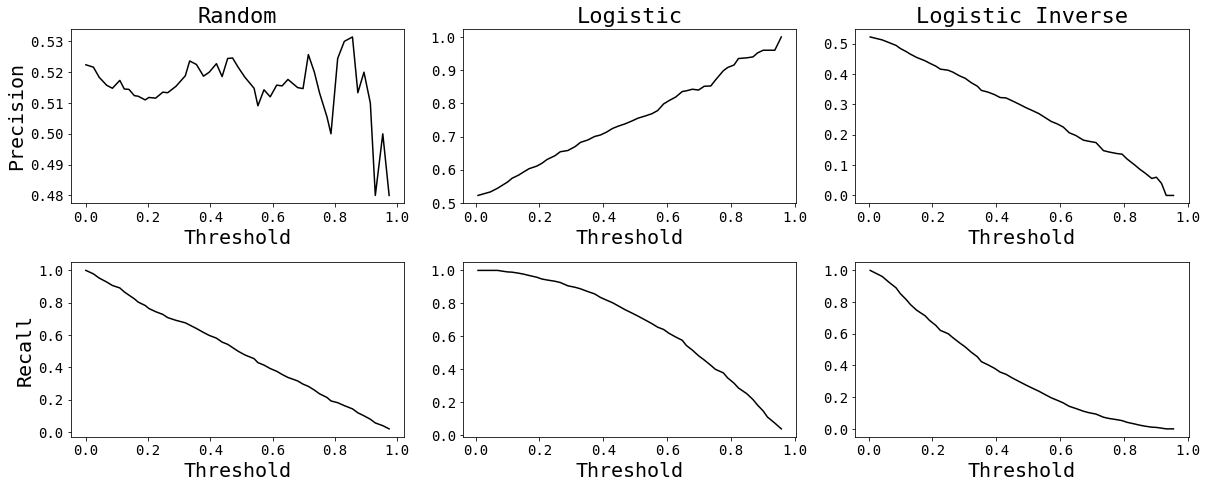

In [507]:
# Transpose everything: easier to read 
fig, ax = plt.subplots(2,3, figsize = (17,7))
dict_df = {0:df_pr_rnd, 1:df_pr, 2:df_pr_inv}
dict_ylab = {0:'Random', 1:'Logistic', 2:'Logistic Inverse'}
for i in range(3):
    df_i = dict_df[i]
    for k,metric in enumerate(['precision','recall']):
        df_i[metric].plot(ax=ax[k,i])
        ax[k,0].set_ylabel(metric.capitalize())
        ax[k,i].set_xlabel('Threshold')
    ax[0,i].set_title(dict_ylab[i])
    

Text(0.5, 0, 'FPR')

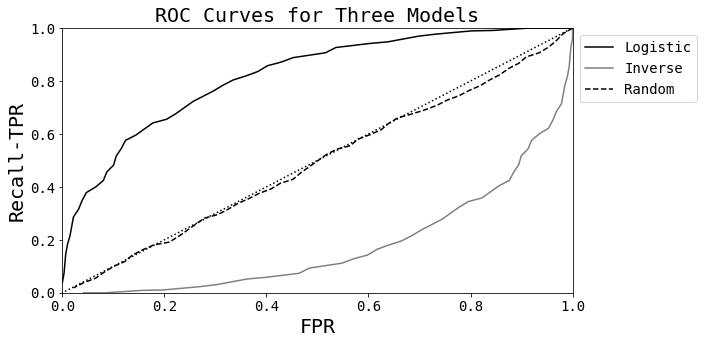

In [508]:
# plot ROC curves
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_pr.fpr, df_pr.recall, color = '0.0')
ax.plot(df_pr_inv.fpr, df_pr_inv.recall, color = '0.5')
ax.plot(df_pr_rnd.fpr, df_pr_rnd.recall, ls = '--')
ax.legend(['Logistic', 'Inverse', 'Random'],bbox_to_anchor=(1.0, 1.0))
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax],[xmin, xmax], ls = 'dotted')
ax.axis([0, 1, 0, 1])
ax.set_title('ROC Curves for Three Models', fontsize=20)
ax.set_ylabel('Recall-TPR')
ax.set_xlabel('FPR')

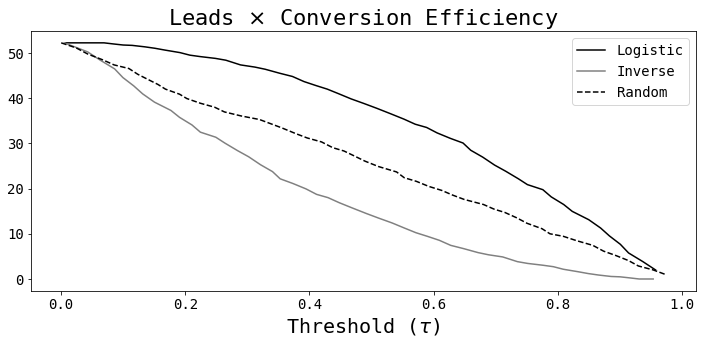

In [509]:
# let's plot volume x precision
fig, ax = plt.subplots(figsize=(10,5))
df_pr.volume_precision.plot(ax=ax, color='0.0')
df_pr_inv.volume_precision.plot(ax=ax, color='0.5')
df_pr_rnd.volume_precision.plot(ax=ax, ls='--')
ax.legend(['Logistic', 'Inverse', 'Random'],bbox_to_anchor=(1.0, 1.0))
ax.set_title(r'Leads $\times$ Conversion Efficiency')
xlab = ax.set_xlabel(r'Threshold ($\tau$)')

% of 1s = 10.0%
% of 1s = 50.0%
% of 1s = 90.0%


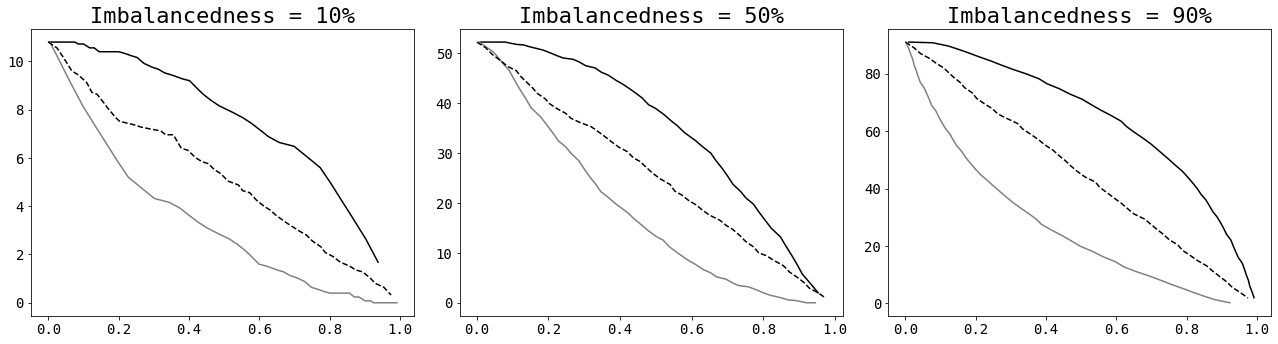

In [510]:
# let's simulate different imbalanced rates to check this
imb_grid = [0.1,0.5,0.9]
fig, ax = plt.subplots(1,3,figsize=(18,5))
for i, imb in enumerate(imb_grid):
    yi, xi = simu_latent_missing(alpha, var_epsilon, num_observed, seed, nobs, pct_imb=imb)
    # train models 
    x_tr, x_ts, y_tr, y_ts = train_test_split(xi, yi, test_size=0.25, random_state=2506)    
    y_trb, x_trb  = balance_data(ydf=y_tr, xdf=x_tr, method='over')
    reg = LogisticRegression(random_state=0).fit(x_trb, y_trb)
    rand_reg = MyRandClassifier()    
    # calculate precisions
    df_pr_i = calculate_precision(model=reg, num_groups=50, xdf=x_ts, y=y_ts)
    df_pr_inv_i = calculate_precision(model=reg, num_groups=50, xdf=x_ts, y=y_ts, inverse_prob=True)
    df_pr_rnd_i = calculate_precision(model=rand_reg, num_groups=50, xdf=x_ts, y=y_ts)    
    # plot
    df_pr_i.volume_precision.plot(ax=ax[i], color='0.0')
    df_pr_inv_i.volume_precision.plot(ax=ax[i], color='0.5')
    df_pr_rnd_i.volume_precision.plot(ax=ax[i], ls='--')
    #ax[i].legend(['Logistic', 'Inverse', 'Random'],bbox_to_anchor=(1.0, 1.0))
    ax[i].set_title(f'Imbalancedness = {int(100*imb)}%')

% of 1s = 10.0%
% of 1s = 50.0%
% of 1s = 90.0%


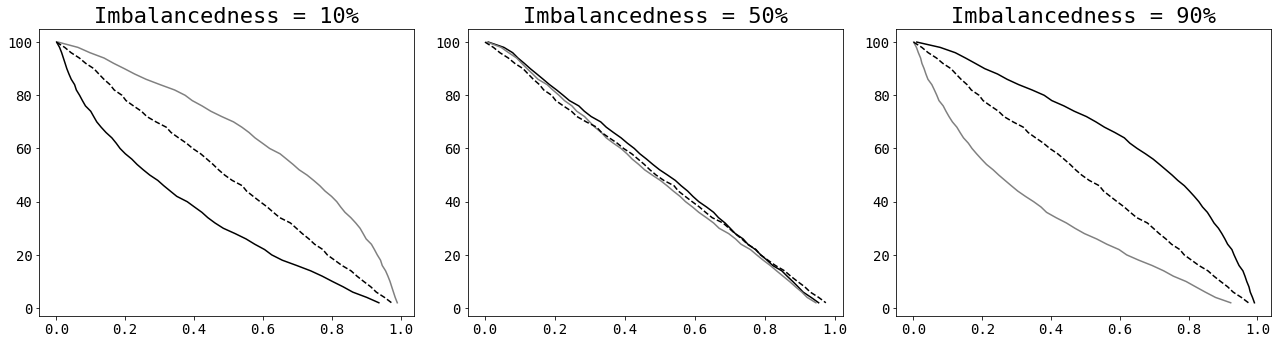

In [511]:
# Volume
imb_grid = [0.1,0.5,0.9]
fig, ax = plt.subplots(1,3,figsize=(18,5))
for i, imb in enumerate(imb_grid):
    yi, xi = simu_latent_missing(alpha, var_epsilon, num_observed, seed, nobs, pct_imb=imb)
    # train models 
    x_tr, x_ts, y_tr, y_ts = train_test_split(xi, yi, test_size=0.25, random_state=2506)    
    y_trb, x_trb  = balance_data(ydf=y_tr, xdf=x_tr, method='over')
    reg = LogisticRegression(random_state=0).fit(x_trb, y_trb)
    rand_reg = MyRandClassifier()    
    # calculate precisions using test sample
    df_pr_i = calculate_precision(model=reg, num_groups=50, xdf=x_ts, y=y_ts)
    df_pr_inv_i = calculate_precision(model=reg, num_groups=50, xdf=x_ts, y=y_ts, inverse_prob=True)
    df_pr_rnd_i = calculate_precision(model=rand_reg, num_groups=50, xdf=x_ts, y=y_ts)    
    # plot
    df_pr_i.volume.plot(ax=ax[i], color='0.0')
    df_pr_inv_i.volume.plot(ax=ax[i], color='0.5')
    df_pr_rnd_i.volume.plot(ax=ax[i], ls='--')
    #ax[i].legend(['Logistic', 'Inverse', 'Random'],bbox_to_anchor=(1.0, 1.0))
    ax[i].set_title(f'Imbalancedness = {int(100*imb)}%')

## Let's do some confusion matrix optimization
* Idea is to maximize `expected profit` or minimize `expected costs`
* Probabilities come from the confusion matrix given a threshold
* Costs are provided by the user

In [512]:
def cost_conf_mat(confmat_df, cost_df):
    """
    Calculate expected cost using a confusion matrix and 
        user-provided costs
    Inputs:
        confmat_df: resulting df from calculate_precision
        cost_df: DF with costs
    Output:
        DF with expected costs and profits for all thresholds in confmat_df
    """
    cols = ['prob_fp', 'prob_fn', 'prob_tp', 'prob_tn', 'exp_cost', 'exp_profits']
    exp_cost_df = pd.DataFrame(index=confmat_df.index, columns = cols)
    # compute probabilities
    sum_cases = confmat_df[['tp', 'tn', 'fp', 'fn']].sum(axis=1)
    sum_negatives = confmat_df[['fp', 'fn']].sum(axis=1)
    exp_cost_df['prob_fp'] = confmat_df.fp/sum_cases
    exp_cost_df['prob_fn'] = confmat_df.fn/sum_cases
    exp_cost_df['prob_tp'] = confmat_df.tp/sum_cases
    exp_cost_df['prob_tn'] = confmat_df.tn/sum_cases
    # expected cost
    exp_cost_df['exp_cost'] = (exp_cost_df.prob_fp * cost_df['pred_pos'].loc['neg']
                              + exp_cost_df.prob_fn * cost_df['pred_neg'].loc['pos'])
    # expected profit
    exp_cost_df['exp_profit'] = (exp_cost_df.prob_tp * cost_df['pred_pos'].loc['pos']
                               +exp_cost_df.prob_tn * cost_df['pred_neg'].loc['neg']
                              -exp_cost_df.prob_fp * cost_df['pred_pos'].loc['neg']
                              - exp_cost_df.prob_fn * cost_df['pred_neg'].loc['pos'])
    
    
    return exp_cost_df

Text(0.5, 1.0, 'Prediction Error Expected Profit')

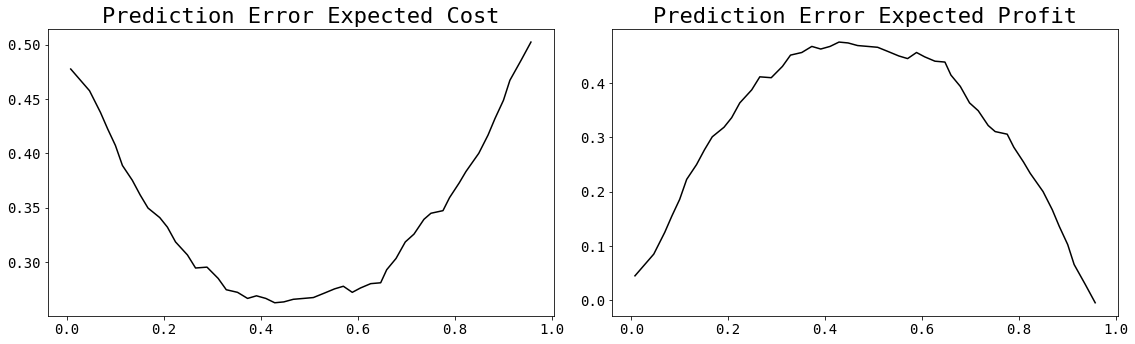

In [513]:
# Simulate some costs
cost_df = pd.DataFrame([[1,1],[1,1]], columns = ['pred_neg', 'pred_pos'], index = ['neg', 'pos'])
econ_df = cost_conf_mat(confmat_df = df_pr, cost_df=cost_df)
fig, ax = plt.subplots(1,2, figsize = (16,5))
econ_df.exp_cost.plot(ax=ax[0])
ax[0].set_title('Prediction Error Expected Cost')
econ_df.exp_profit.plot(ax=ax[1])
ax[1].set_title('Prediction Error Expected Profit')


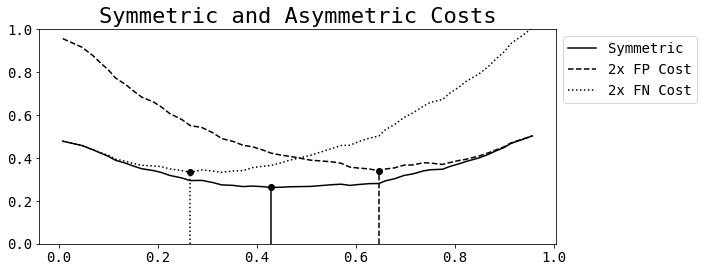

In [514]:
# show symmetric and asymmetric cases
dict_sym = {0:[[1,1],[1,1]], 1:[[1,2],[1,1]], 2:[[1,1],[2,1]]}
fig, ax = plt.subplots()
lsmat = ['-', '--', 'dotted']
for i in range(3):
    mat_i = dict_sym[i]
    c_df = pd.DataFrame(mat_i, columns = ['pred_neg', 'pred_pos'], index = ['neg', 'pos'])
    e_df = cost_conf_mat(confmat_df = df_pr, cost_df=c_df)
    e_df.exp_cost.plot(ax=ax, ls = lsmat[i])
    # find minimum
    tau_min = e_df.exp_cost.idxmin()
    y_min = e_df.exp_cost.loc[tau_min]
    #ax.plot([tau_min, tau_min], [0, y_min], ls = lsmat[i])
    #ax.scatter([tau_min], [y_min], marker='o')
    
ax.legend(['Symmetric', '2x FP Cost', '2x FN Cost'], bbox_to_anchor=(1.0, 1.0))
ax.set_ylim([0,1])
ax.set_title('Symmetric and Asymmetric Costs')

# get mins
for i in range(3):
    mat_i = dict_sym[i]
    c_df = pd.DataFrame(mat_i, columns = ['pred_neg', 'pred_pos'], index = ['neg', 'pos'])
    e_df = cost_conf_mat(confmat_df = df_pr, cost_df=c_df)
    # find minimum
    tau_min = e_df.exp_cost.idxmin()
    y_min = e_df.exp_cost.loc[tau_min]
    ax.plot([tau_min, tau_min], [0, y_min], ls = lsmat[i])
    ax.scatter([tau_min], [y_min], marker='o')
